## Library

In [11]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [12]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [13]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.6,
 5: 26.0,
 10: 26.7,
 20: 27.7,
 30: 28.6,
 40: 29.7,
 50: 31.3,
 60: 33.3,
 70: 35.4,
 80: 37.9,
 90: 41.5,
 95: 44.6,
 99: 50.301000000000016}

In [14]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [15]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.15 weight on <Distribution> lognorm(mean=2.47, sd=0.32)},
 'integration': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.76, sd=0.7)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distrib

In [16]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [17]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 976191.41it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.0003064318841227333,
 50: 0.00038725988709628005,
 60: 0.0005043195107217104,
 70: 0.0007098649597995664,
 80: 0.0010829832640776081,
 90: 0.0022606096332511284,
 95: 0.003820440311419332,
 99: 0.009143160036222436}

In [18]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.0e+09',
 50: '8.9e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.5e+10',
 90: '5.2e+10',
 95: '8.8e+10',
 99: '2.1e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 4.0 years to a max of 0.055765% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (150 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 7.8 (59 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (226 septillion) available - TAI

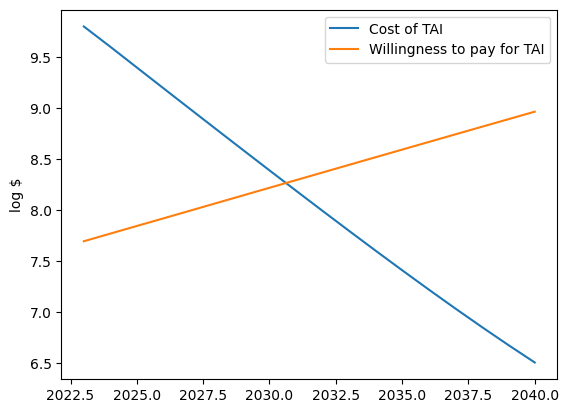

-
-
## SAMPLE RUN 2 ##
It takes 38.2 log FLOP (~158 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.9 to buy TAI (79 quintillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (472 septillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.5 to buy TAI (29 quintillion) vs. willingness to pay log $ 8.2 (173 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max 

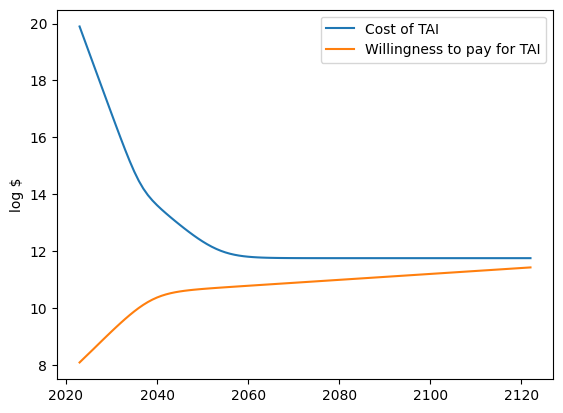

-
-
## SAMPLE RUN 3 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~464 million). This doubles every 3.0 years to a max of 0.027359% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.9 max log FLOP (863 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.7 to buy TAI (501 million) vs. willingness to pay log $ 8.6 (432 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.5 to buy TAI (294 million) vs. willingness to pay log $ 8.7 (536 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_nonscaling_issue p=0.9479 -> Nonscaling del

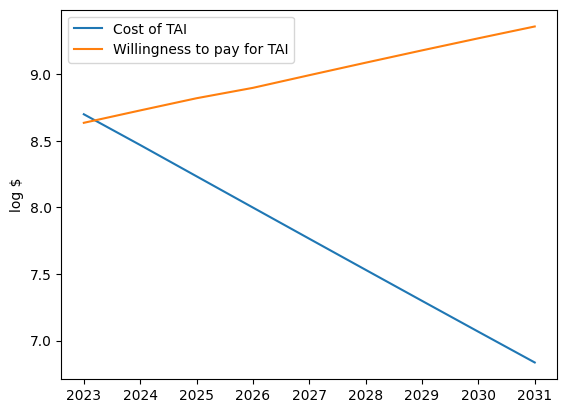

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.56it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1410.13it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2034',
 '20%: 2036',
 '25%: 2037',
 '35%: 2040',
 '50%: 2046',
 '60%: 2052',
 '75%: 2080',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 8 years from now',
 '10%: 10 years from now',
 '15%: 11 years from now',
 '20%: 13 years from now',
 '25%: 14 years from now',
 '35%: 17 years from now',
 '50%: 23 years from now',
 '60%: 29 years from now',
 '75%: 57 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.2%
2028-2029: 2.1%
2030-2034: 13.5%
2035-2039: 18.8%
2040-2049: 21.8%
2050-2059: 10.7%
2060-2069: 4.8%
2070-2079: 2.8%
2080-2089: 1.4%
2090-2099: 0.9%
2100-2109: 0.6%
2110-2119: 0.3%
>2120: 21.8%
-
-


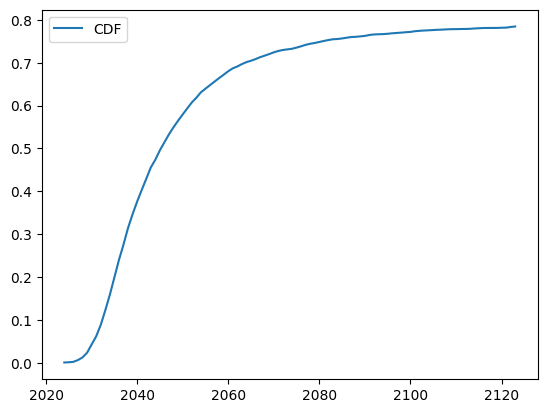

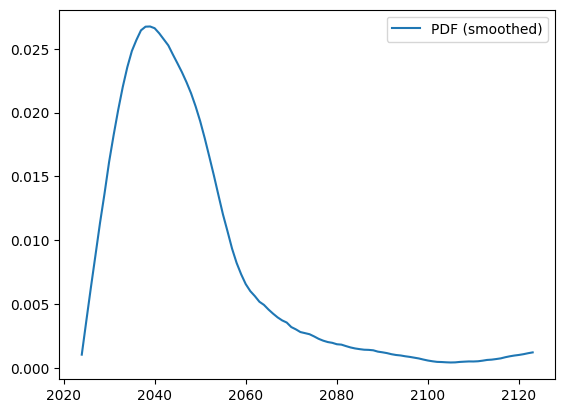

-
-
## TAI FLOP SIZE ##
{1: 24.2,
 5: 25.9,
 10: 26.5,
 20: 27.6,
 30: 28.5,
 40: 29.5,
 50: 31.0,
 60: 32.7,
 70: 34.9,
 80: 37.6,
 90: 41.5,
 95: 44.6,
 99: 49.7}


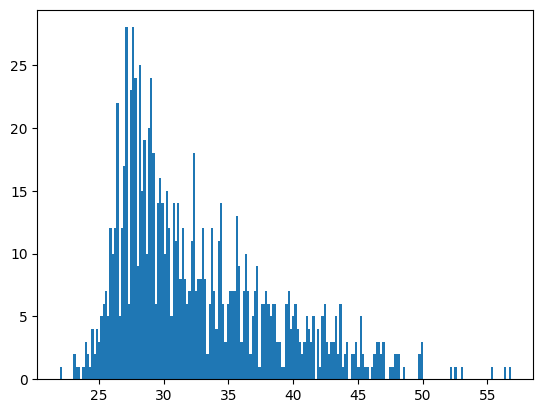

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.3,
 90: 2.1,
 95: 2.0,
 99: 1.8}


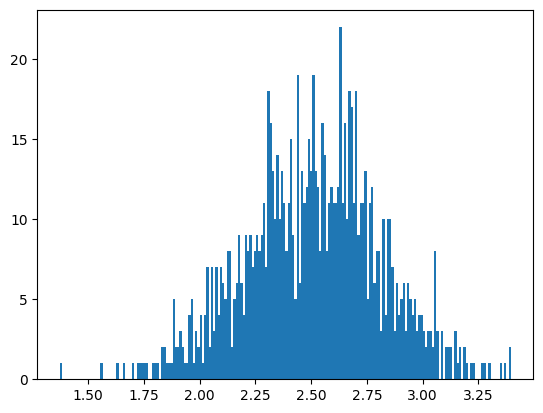

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.5,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.2,
 50: 22.5,
 60: 22.7,
 70: 22.9,
 80: 23.2,
 90: 23.7,
 95: 24.0,
 99: 24.7}


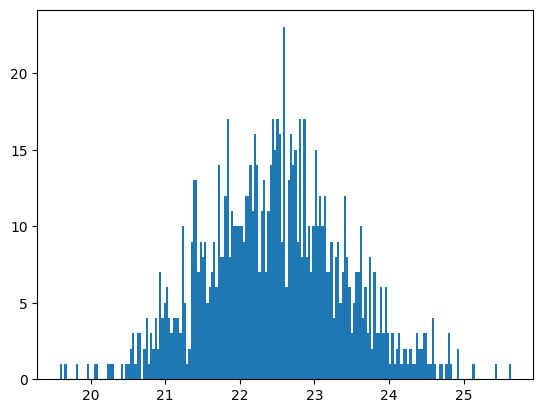

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.4,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.7}


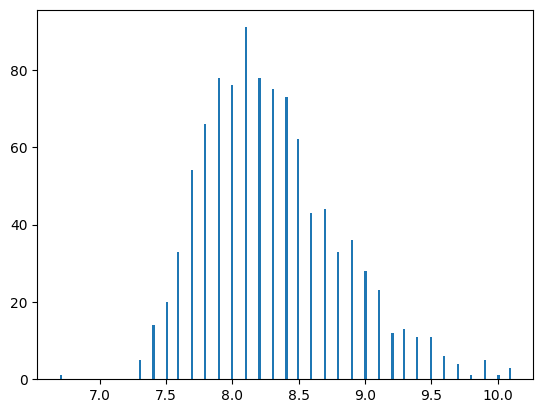

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


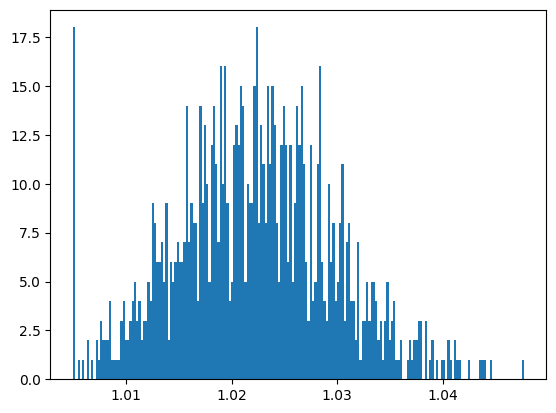

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.0003,
 50: 0.00039,
 60: 0.0005,
 70: 0.00065,
 80: 0.00103,
 90: 0.0022,
 95: 0.00364,
 99: 0.01017}


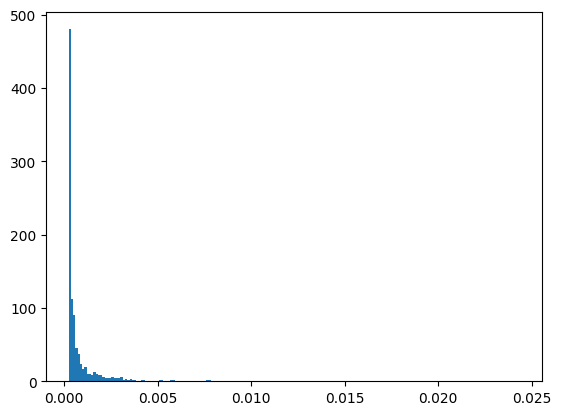

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.5,
 10: 4.2,
 20: 3.8,
 30: 3.5,
 40: 3.3,
 50: 3.0,
 60: 2.7,
 70: 2.5,
 80: 2.1,
 90: 1.8,
 95: 1.5,
 99: 1.0}


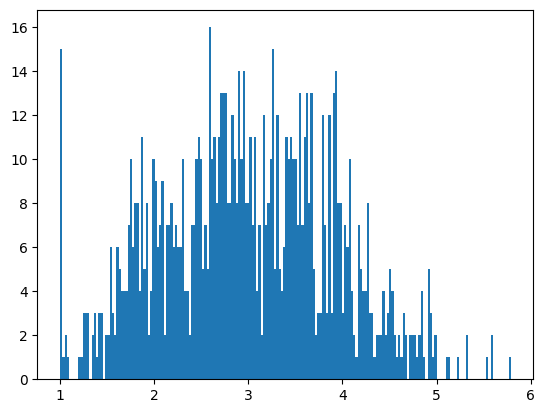

-
-
-
-
## GDP Over Time ##


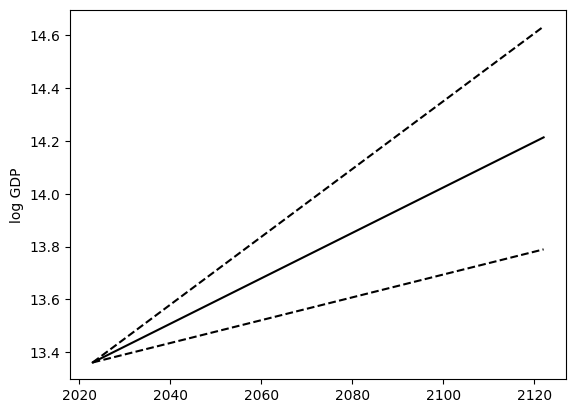

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

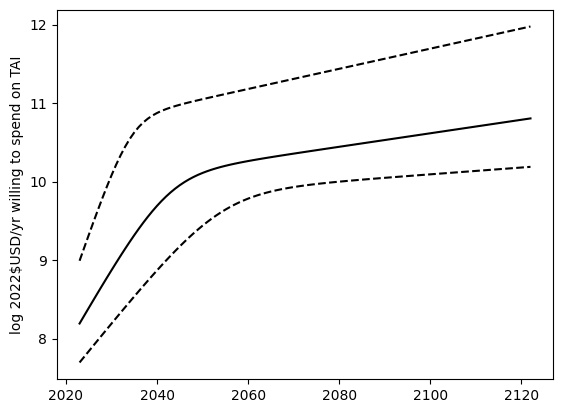

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~50 million) - 9.0 (~981 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~195 million) 90% CI 7.8 (~59 million) - 9.2 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.8 (~69 million) - 9.3 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.9 (~81 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 8.0 (~95 million) - 9.6 (~4 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~479 million) 90% CI 8.1 (~112 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~597 million) 90% CI 8.1 (~132 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~741 million) 90% CI 8.2 (~155 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~918 million) 90% CI 8.3 (~182 million) - 10.2 (~16 billion)


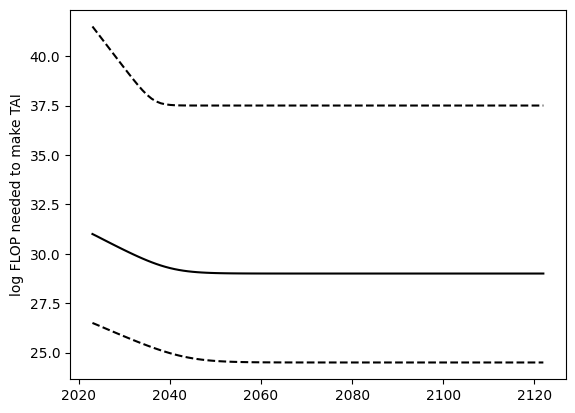

Year: 2023 - log FLOP needed for TAI 31.0 (~10 nonillion) 90% CI 26.5 (~316 septillion) - 41.5 (~316 million decillion)
Year: 2024 - log FLOP needed for TAI 30.9 (~8 nonillion) 90% CI 26.4 (~254 septillion) - 41.2 (~158 million decillion)
Year: 2025 - log FLOP needed for TAI 30.8 (~6 nonillion) 90% CI 26.3 (~202 septillion) - 40.9 (~79 million decillion)
Year: 2026 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.2 (~161 septillion) - 40.6 (~40 million decillion)
Year: 2027 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 26.1 (~129 septillion) - 40.3 (~20 million decillion)
Year: 2028 - log FLOP needed for TAI 30.4 (~3 nonillion) 90% CI 26.0 (~103 septillion) - 40.0 (~10 million decillion)
Year: 2029 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.9 (~82 septillion) - 39.7 (~5 million decillion)
Year: 2030 - log FLOP needed for TAI 30.2 (~2 nonillion) 90% CI 25.8 (~66 septillion) - 39.4 (~3 million decillion)
Year: 2031 - log FLOP needed for TAI 30.1 (~1 nonillion) 

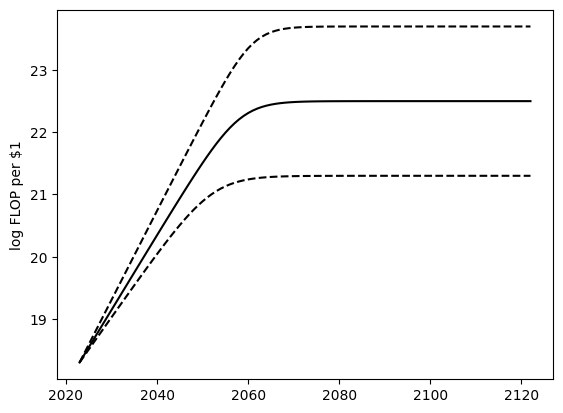

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

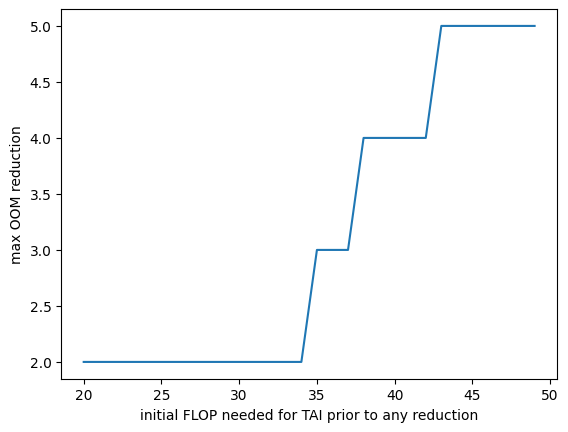

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

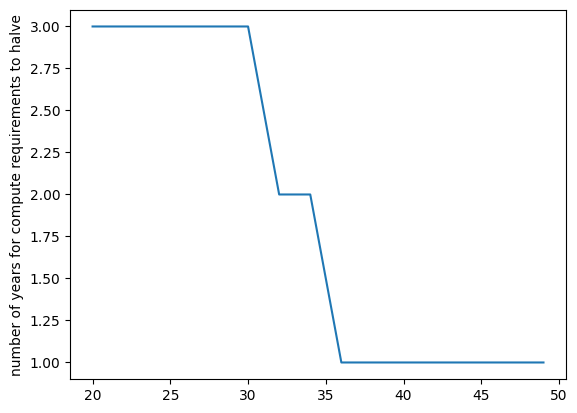

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

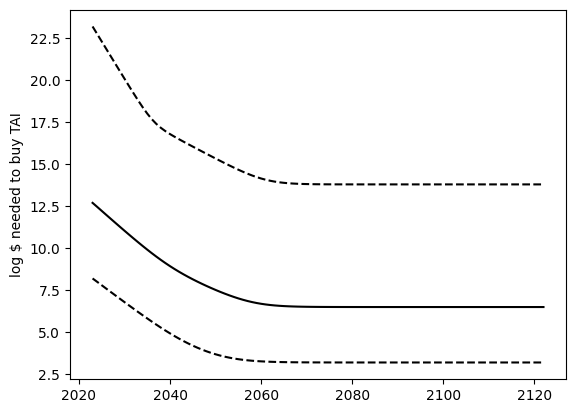

Year: 2023 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 8.2 (~159 million) - 23.2 (~158 sextillion)
Year: 2024 - 12.5 log 2022$USD to buy TAI (~3 trillion) 90% CI 8.0 (~100 million) - 22.8 (~57 sextillion)
Year: 2025 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.8 (~63 million) - 22.3 (~20 sextillion)
Year: 2026 - 12.0 log 2022$USD to buy TAI (~972 billion) 90% CI 7.6 (~40 million) - 21.9 (~7 sextillion)
Year: 2027 - 11.7 log 2022$USD to buy TAI (~562 billion) 90% CI 7.4 (~25 million) - 21.4 (~3 sextillion)
Year: 2028 - 11.5 log 2022$USD to buy TAI (~326 billion) 90% CI 7.2 (~16 million) - 21.0 (~954 quintillion)
Year: 2029 - 11.3 log 2022$USD to buy TAI (~189 billion) 90% CI 7.0 (~10 million) - 20.5 (~344 quintillion)
Year: 2030 - 11.0 log 2022$USD to buy TAI (~111 billion) 90% CI 6.8 (~6 million) - 20.1 (~124 quintillion)
Year: 2031 - 10.8 log 2022$USD to buy TAI (~65 billion) 90% CI 6.6 (~4 million) - 19.7 (~45 quintillion)
Year: 2032 - 10.6 log 2022$USD to buy TAI (~

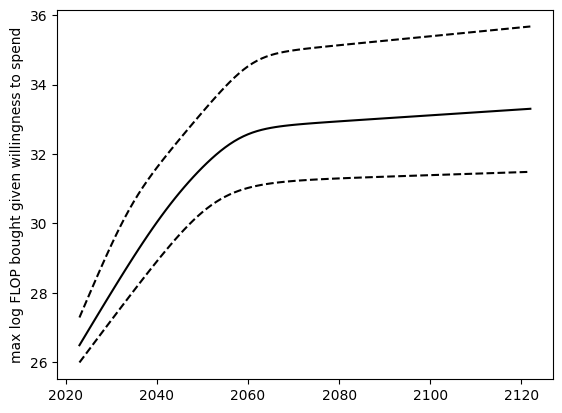

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~99 septillion) - 27.3 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~514 septillion) 90% CI 26.2 (~148 septillion) - 27.6 (~4 octillion)
Year: 2025 - max log FLOP 26.9 (~851 septillion) 90% CI 26.3 (~221 septillion) - 27.9 (~8 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~331 septillion) - 28.2 (~16 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~494 septillion) - 28.5 (~32 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~738 septillion) - 28.8 (~64 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.0 (~1 octillion) - 29.1 (~125 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.4 (~241 octillion)
Year: 2031 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~2 octillion) - 29.7 (~455 octillion)
Year: 2032 - max log FLOP 28.4 (~27 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~839 octillion)
Year: 2033

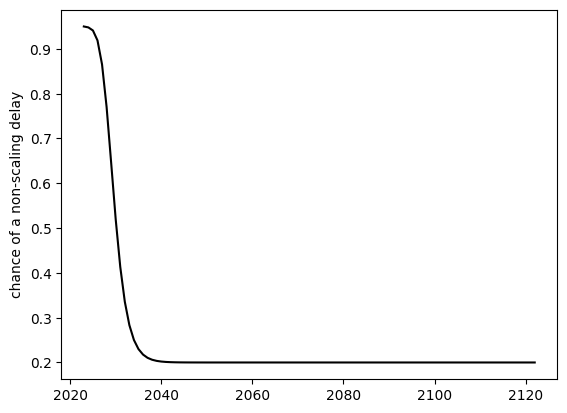

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 94%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 77%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 52%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2033

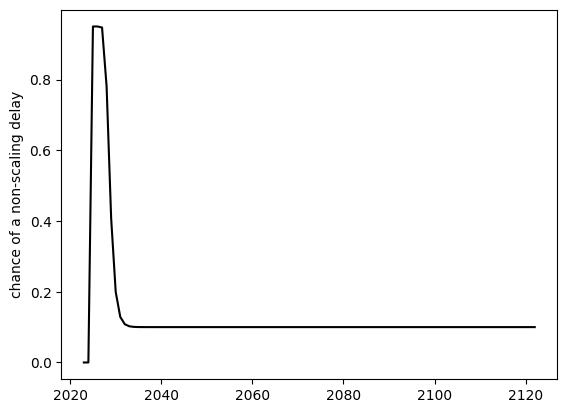

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 78%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 -

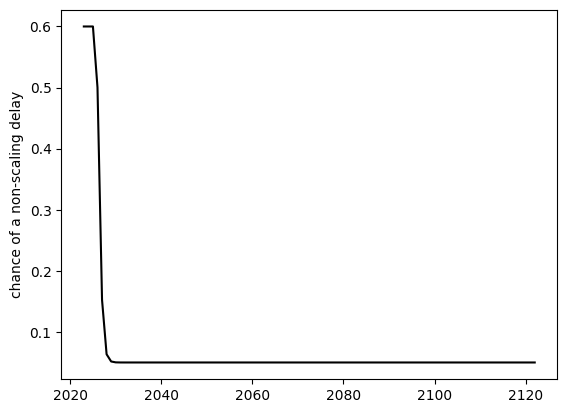

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

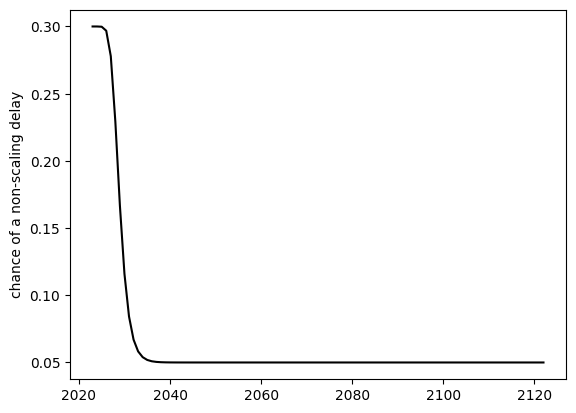

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

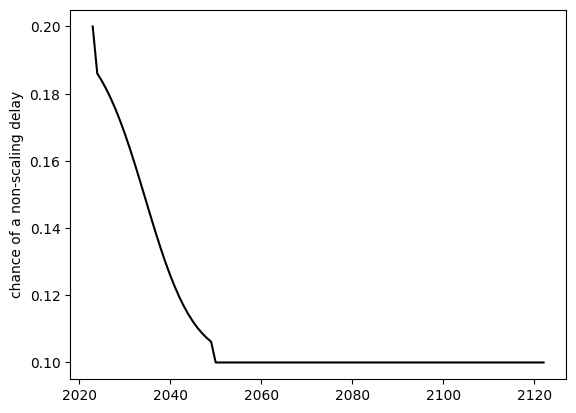

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033

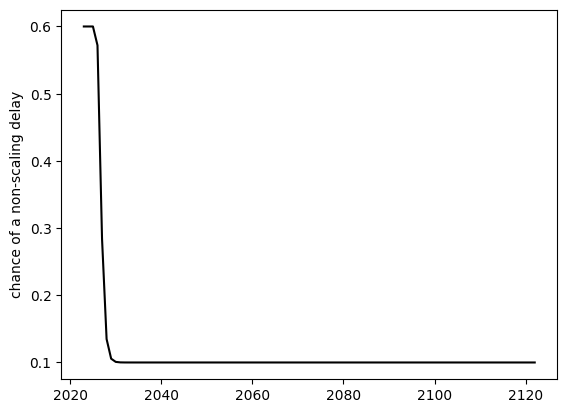

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

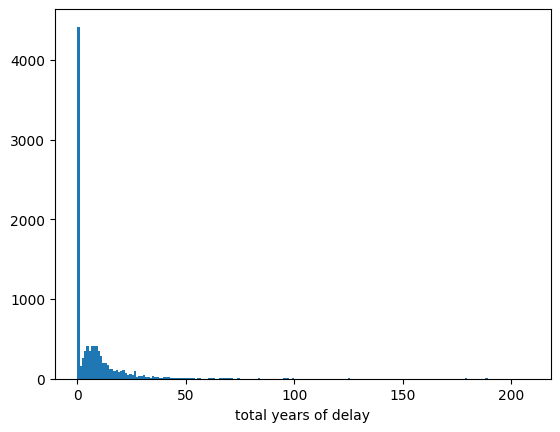

In [19]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~486 quintillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.5 max log FLOP (298 septillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (798 trillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (651 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (444 trillion) vs. willingness to pay log $ 8.4 (254 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available

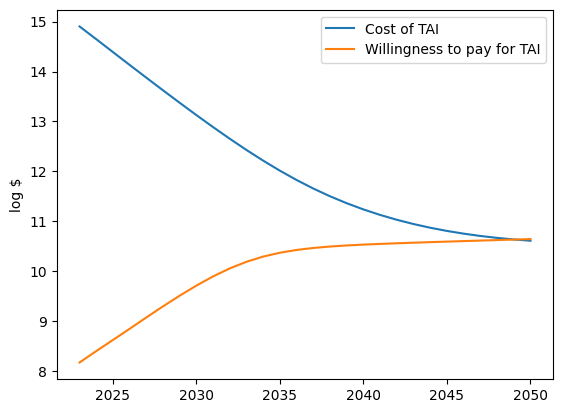

-
-
## SAMPLE RUN 5 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~158 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.6 years to a max of 0.059742% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (211 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 7.9 (82 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (356 septillion) available - 

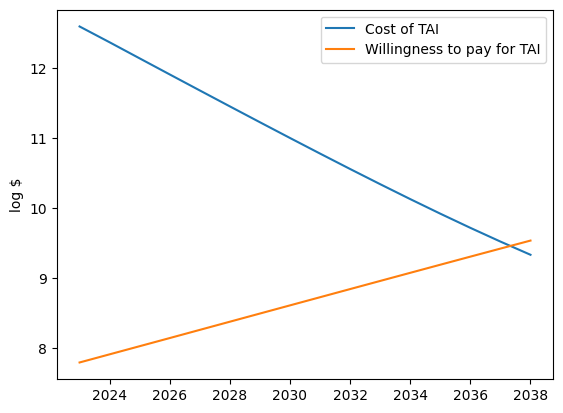

-
-
## SAMPLE RUN 6 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 11.6 to buy TAI (398 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (293 septillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 11.4 to buy TAI (253 billion) vs. willingness to pay log $ 8.1 (116 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (445 septillion) availab

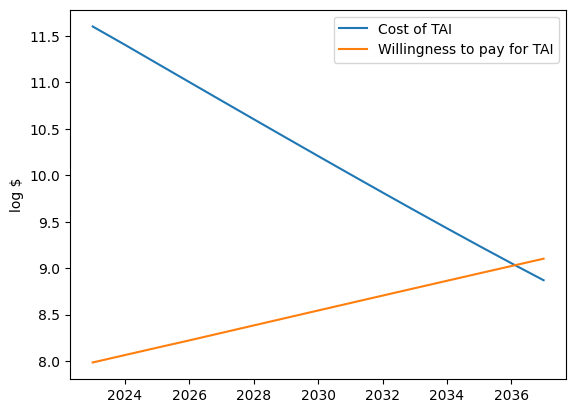

-
-
## SAMPLE RUN 7 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 4.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 14.2 to buy TAI (159 trillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (446 septillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 14.0 to buy TAI (90 trillion) vs. willingness to pay log $ 8.2 (176 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (662 septillion) avai

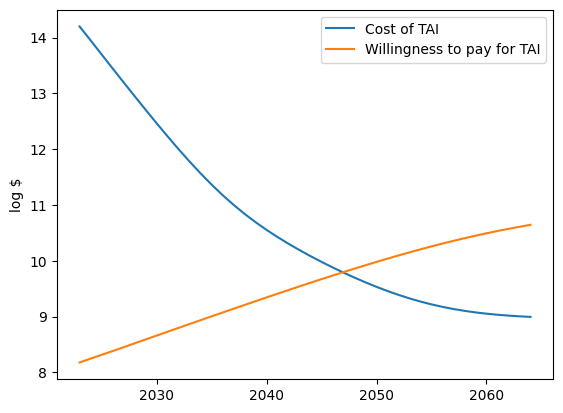

-
-
## SAMPLE RUN 8 ##
It takes 29.8 log FLOP (~631 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 29.8 log FLOP (631 octillion) - log $ 11.5 to buy TAI (316 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (382 septillion) available - TAI takes 29.7 log FLOP (507 octillion) - log $ 11.3 to buy TAI (193 billion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (606 septillion) avai

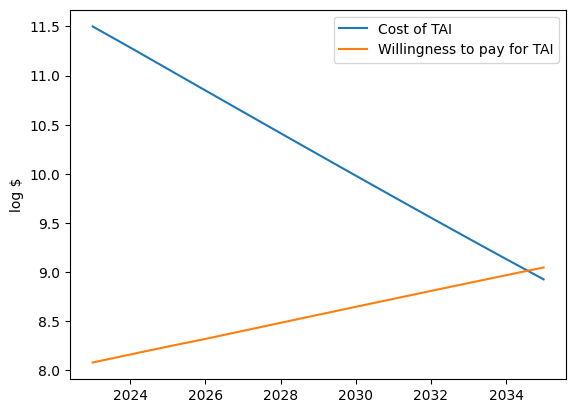

-
-
## SAMPLE RUN 9 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~103 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (61 quadrillion) vs. willingness to pay log $ 8.6 (428 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) ava

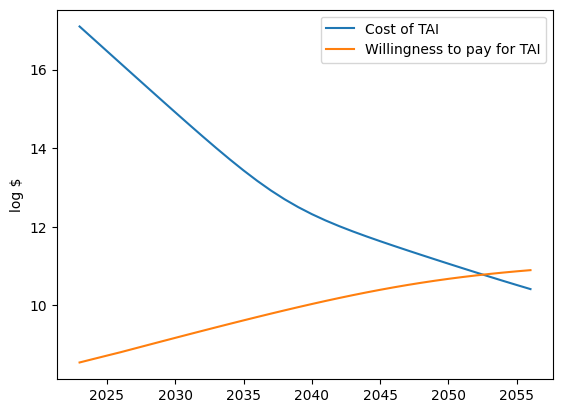

-
-
## SAMPLE RUN 10 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~384 million). This doubles every 2.3 years to a max of 0.045826% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.9 max log FLOP (738 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.6 (370 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.7 (492 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (2 octillion) available - TAI take

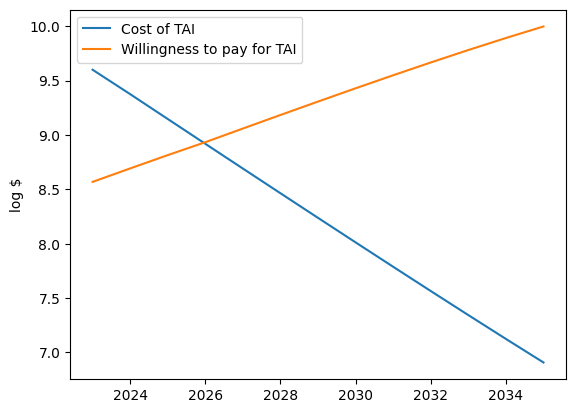

-
-
## SAMPLE RUN 11 ##
It takes 33.4 log FLOP (~3 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 3.5 years to a max of 0.052075% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.6 max log FLOP (385 septillion) available - TAI takes 33.4 log FLOP (3 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.3 (193 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (636 septillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 14.8 to buy TAI (665 trillion) vs. willingness to pay log $ 8.4 (235 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (1 octillion) availab

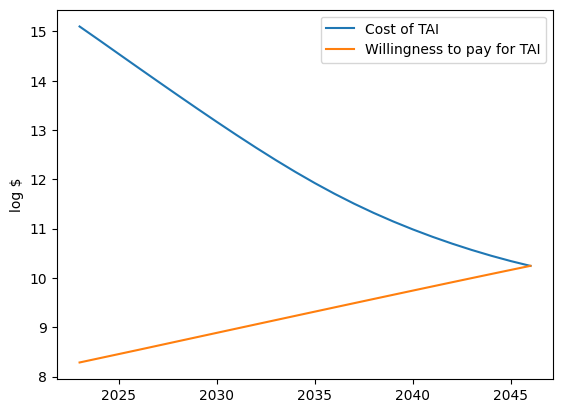

-
-
## SAMPLE RUN 12 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.7 max log FLOP (460 septillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (767 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (15 billion) vs. willingness to pay log $ 8.5 (282 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available - 

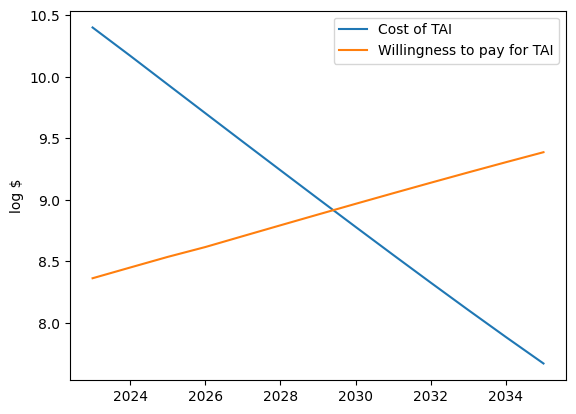

-
-
## SAMPLE RUN 13 ##
It takes 34.9 log FLOP (~79 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 1 years to a max of 0.079857% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.7 max log FLOP (488 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.6 to buy TAI (40 quadrillion) vs. willingness to pay log $ 8.4 (245 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.3 to buy TAI (18 quadrillion) vs. willingness to pay log $ 8.7 (483 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLOP (4 octillion) avail

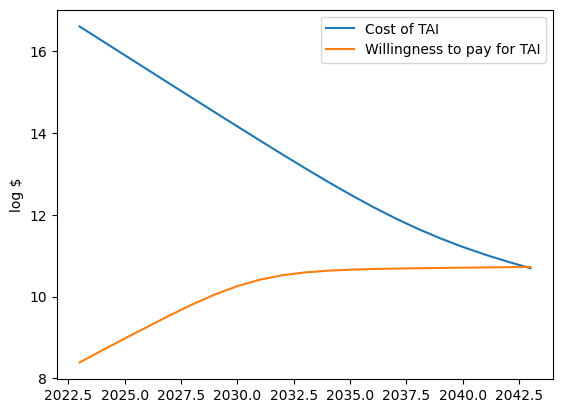

-
-
## SAMPLE RUN 14 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 3.5 years to a max of 0.241286% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.6 max log FLOP (395 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (627 septillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.4 (242 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (996 septillion) avai

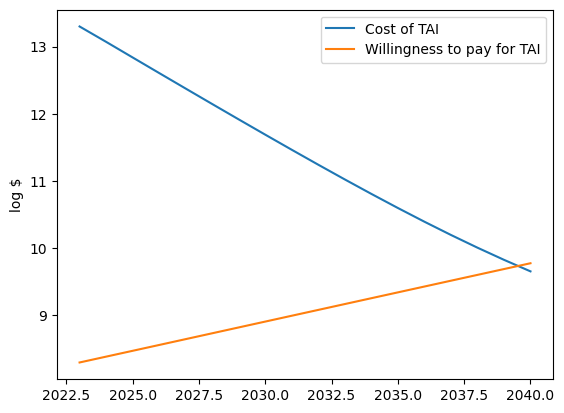

-
-
## SAMPLE RUN 15 ##
It takes 46.9 log FLOP (~79 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~22 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~971 million). This doubles every 2.2 years to a max of 0.144532% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 46.9 log FLOP (79 trillion decillion) - log $ 28.6 to buy TAI (40 octillion) vs. willingness to pay log $ 9.0 (943 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 46.6 log FLOP (40 trillion decillion) - log $ 28.2 to buy TAI (15 octillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.8 max log FLOP (

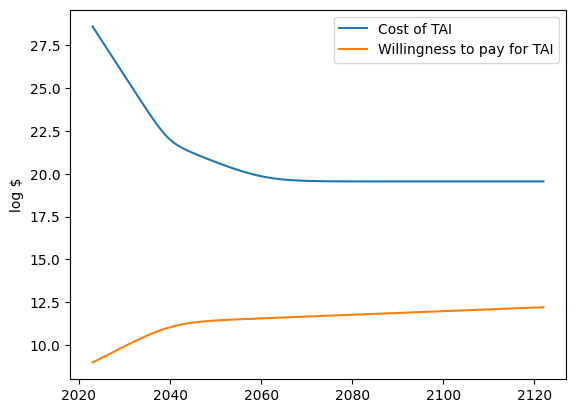

-
-
## SAMPLE RUN 16 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.8 years to a max of 0.025413% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (472 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.3 (179 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (742 septillion) av

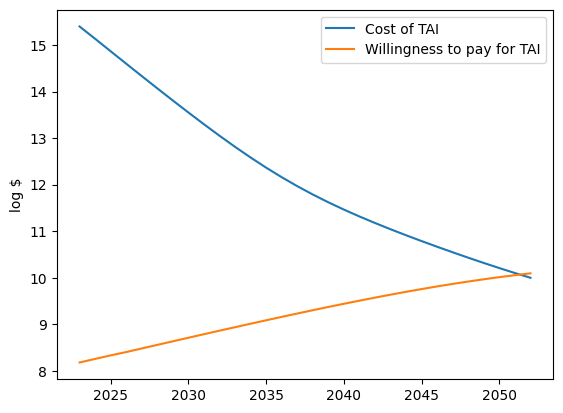

-
-
## SAMPLE RUN 17 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~109 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 2.5 years to a max of 0.058385% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.5 max log FLOP (309 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.2 (155 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (533 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.3 (204 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (917 septillion) available - T

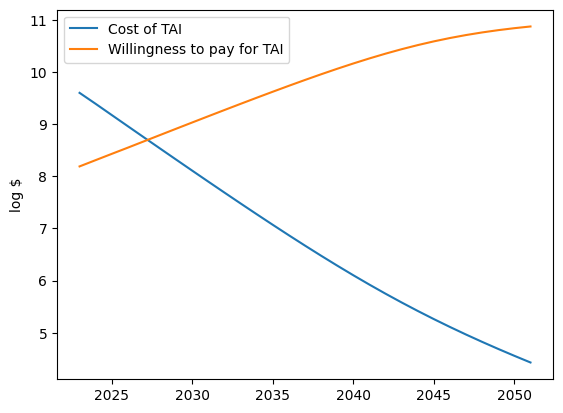

-
-
## SAMPLE RUN 18 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~121 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.1 years to a max of 0.092596% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.7 to buy TAI (5 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (282 septillion) available - TAI takes 33.9 log FLOP (7 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.0 (110 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (504 septillion) a

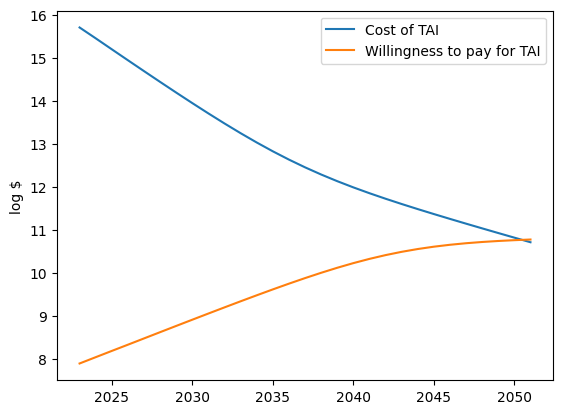

-
-
## SAMPLE RUN 19 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 29.6 log FLOP (398 octillion) - log $ 11.3 to buy TAI (200 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (318 septillion) available - TAI takes 29.5 log FLOP (320 octillion) - log $ 11.1 to buy TAI (117 billion) vs. willingness to pay log $ 8.1 (117 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (523 septillion) availa

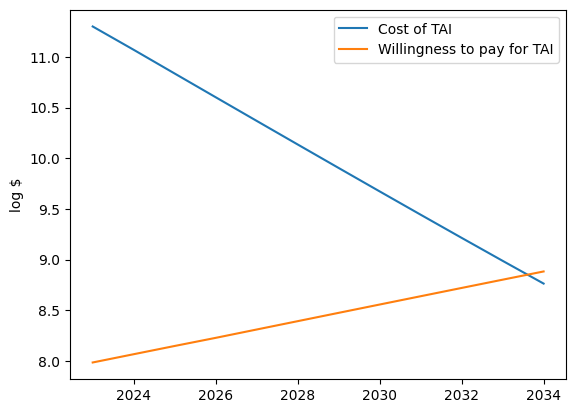

-
-
## SAMPLE RUN 20 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~85 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.7 years to a max of 0.218906% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.1 max log FLOP (126 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.2 to buy TAI (158 billion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (207 septillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.0 to buy TAI (93 billion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (342 septillion) avai

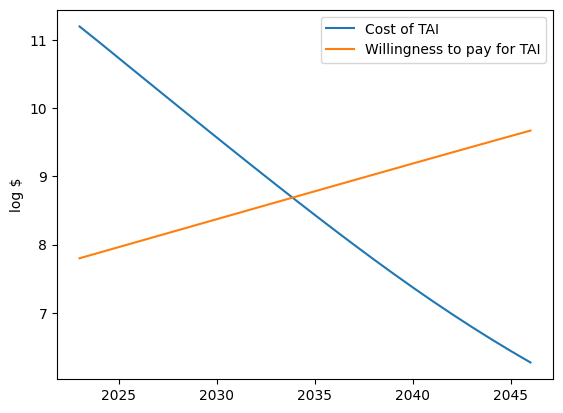

-
-
## SAMPLE RUN 21 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~146 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~392 million). This doubles every 2.4 years to a max of 0.112123% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.9 max log FLOP (771 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (158 million) vs. willingness to pay log $ 8.6 (386 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.6 -> Nonscaling issue did not occur
-- integration 

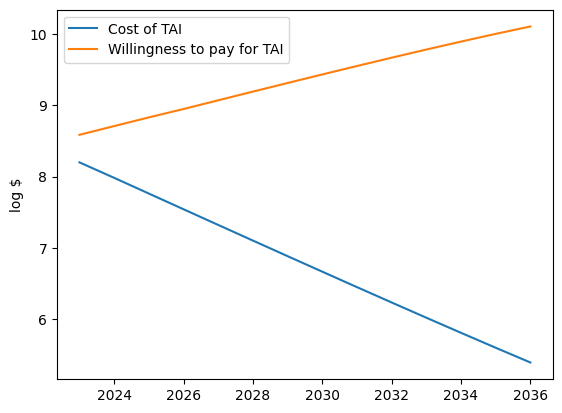

-
-
## SAMPLE RUN 22 ##
It takes 36.5 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~61 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.8 years to a max of 0.284609% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.5 max log FLOP (315 septillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.2 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.2 (158 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (541 septillion) available - TAI takes 36.2 log FLOP (2 thousand decillion) - log $ 17.8 to buy TAI (593 quadrillion) vs. willingness to pay log $ 8.3 (203 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max

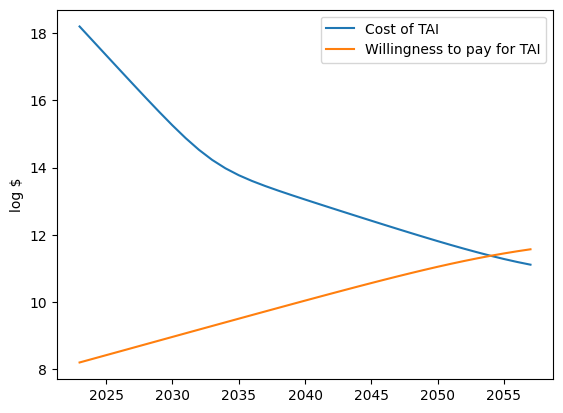

-
-
## SAMPLE RUN 23 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~63 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~624 million). This doubles every 2.7 years to a max of 0.245656% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.8 (617 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (988 million) vs. willingness to pay log $ 8.9 (793 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available - TAI takes

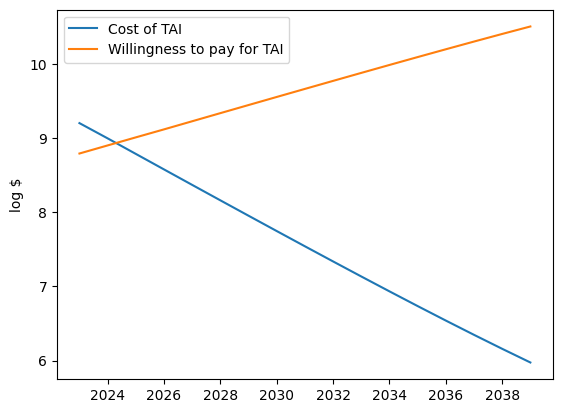

-
-
## SAMPLE RUN 24 ##
It takes 34.2 log FLOP (~16 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~67 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 34.2 log FLOP (16 decillion) - log $ 15.9 to buy TAI (8 quadrillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.9 (766 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available -

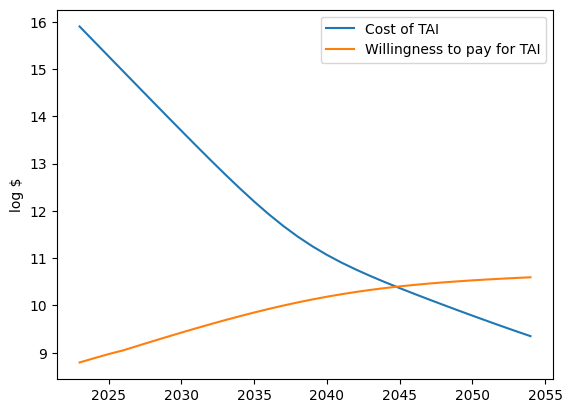

-
-
## SAMPLE RUN 25 ##
It takes 40.3 log FLOP (~20 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~272 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.04x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 40.3 log FLOP (20 million decillion) - log $ 22.0 to buy TAI (10 sextillion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.6 to buy TAI (4 sextillion) vs. willingness to pay log $ 8.9 (790 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 o

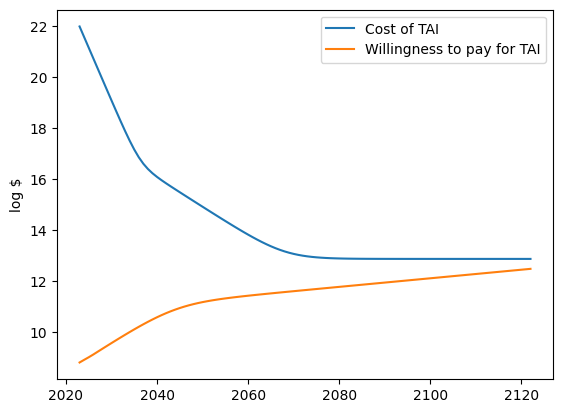

-
-
## SAMPLE RUN 26 ##
It takes 45.2 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~331 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 5.2 years to a max of 0.344104% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.1 max log FLOP (126 septillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 26.9 to buy TAI (794 septillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (196 septillion) available - TAI takes 44.9 log FLOP (792 billion decillion) - log $ 26.5 to buy TAI (291 septillion) vs. willingness to pay log $ 7.9 (72 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max lo

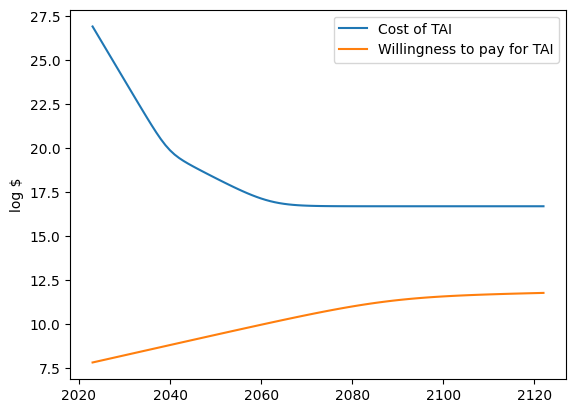

-
-
## SAMPLE RUN 27 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~74 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 3.0 years to a max of 0.273243% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.6 max log FLOP (396 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (667 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.4 (250 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) availabl

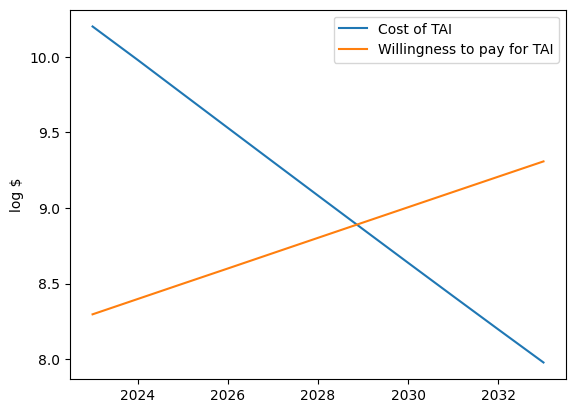

-
-
## SAMPLE RUN 28 ##
It takes 38.0 log FLOP (~100 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.4 years to a max of 0.074092% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.7 to buy TAI (50 quintillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (209 septillion) available - TAI takes 37.7 log FLOP (50 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 7.9 (83 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 ma

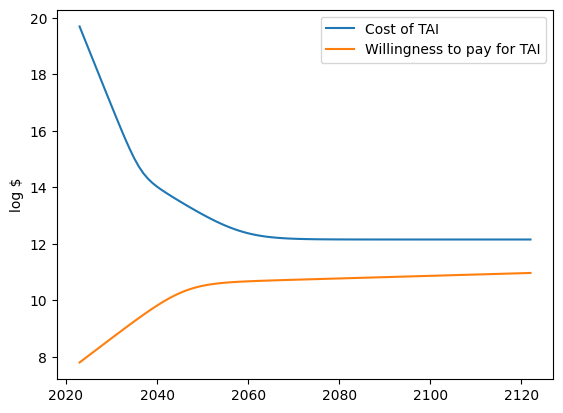

-
-
## SAMPLE RUN 29 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~624 quintillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 2.9 years to a max of 0.165565% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.8 max log FLOP (619 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.5 (311 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 8.6 (394 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available - T

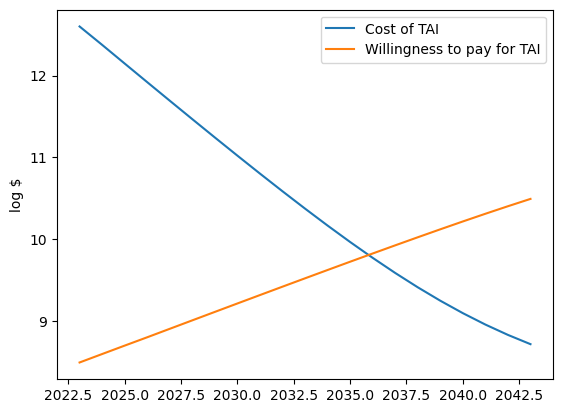

-
-
## SAMPLE RUN 30 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~342 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.7 max log FLOP (5 octillion) available - TAI takes 27.7 log 

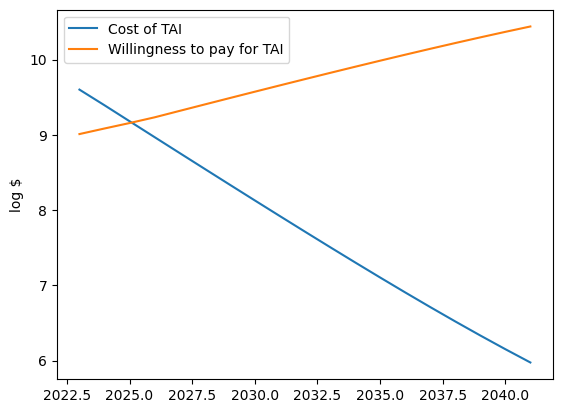

-
-
## SAMPLE RUN 31 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~80 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 4.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.6 (411 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available - TAI takes 2

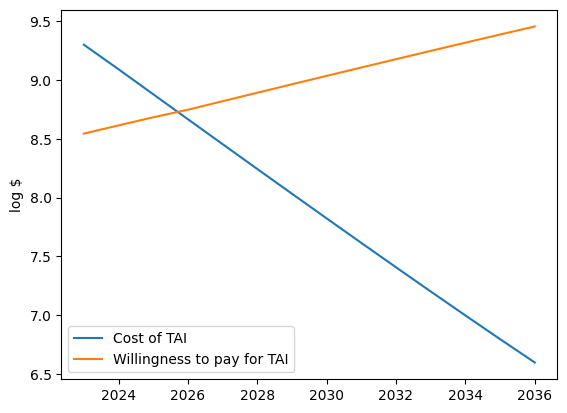

-
-
## SAMPLE RUN 32 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.2 to buy TAI (159 quintillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (654 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.8 to buy TAI (60 quintillion) vs. willingness to pay log $ 8.4 (247 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 m

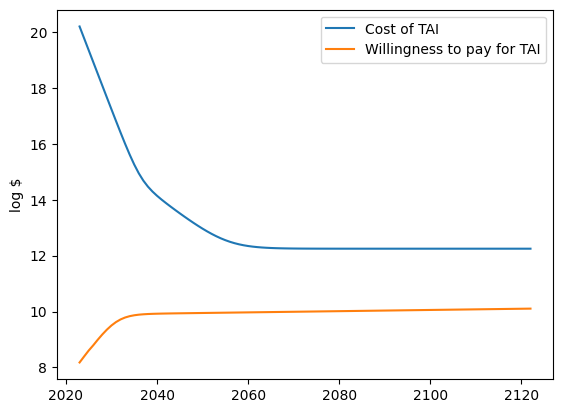

-
-
## SAMPLE RUN 33 ##
It takes 34.9 log FLOP (~79 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~41 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 4.2 years to a max of 0.170927% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.6 to buy TAI (40 quadrillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (302 septillion) available - TAI takes 34.7 log FLOP (50 decillion) - log $ 16.3 to buy TAI (19 quadrillion) vs. willingness to pay log $ 8.1 (117 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (458 septillion

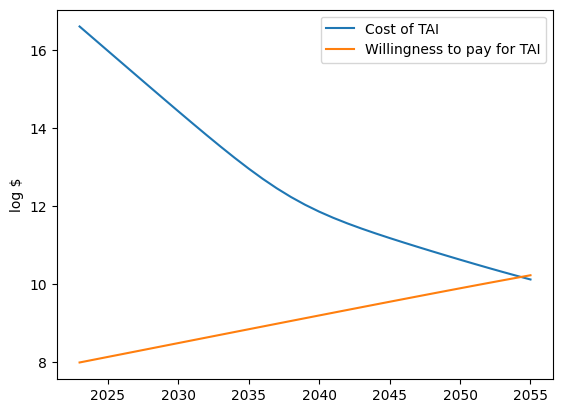

-
-
## SAMPLE RUN 34 ##
It takes 36.4 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (943 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.7 to buy TAI (484 quadrillion) vs. willingness to pay log $ 8.6 (363 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log

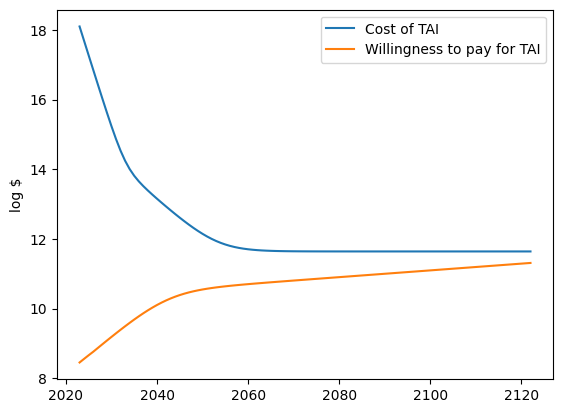

-
-
## SAMPLE RUN 35 ##
It takes 39.2 log FLOP (~2 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 5.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 39.2 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (795 quintillion) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (124 septillion) available - TAI takes 38.9 log FLOP (793 thousand decillion) - log $ 20.5 to buy TAI (288 quintillion) vs. willingness to pay log $ 7.7 (45 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLO

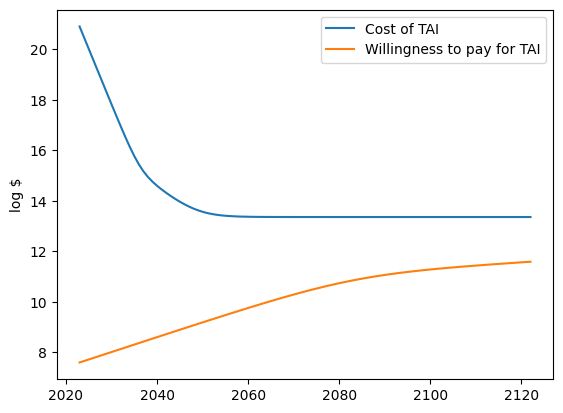

-
-
## SAMPLE RUN 36 ##
It takes 45.2 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~157 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~302 million). This doubles every 3.9 years to a max of 0.02851% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (575 septillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 26.9 to buy TAI (794 septillion) vs. willingness to pay log $ 8.5 (288 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (880 septillion) available - TAI takes 44.9 log FLOP (792 billion decillion) - log $ 26.5 to buy TAI (308 septillion) vs. willingness to pay log $ 8.5 (343 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max 

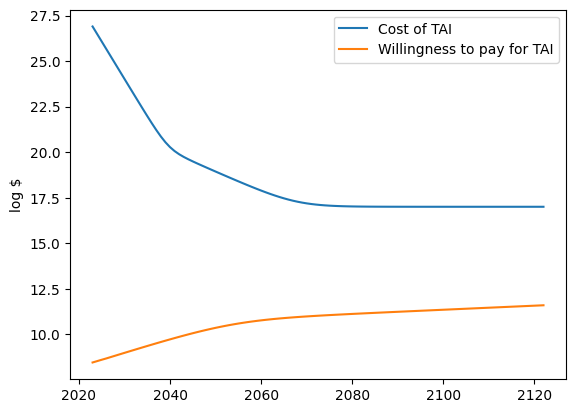

-
-
## SAMPLE RUN 37 ##
It takes 41.0 log FLOP (~100 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 3.7 years to a max of 0.167137% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.7 max log FLOP (495 septillion) available - TAI takes 41.0 log FLOP (100 million decillion) - log $ 22.7 to buy TAI (50 sextillion) vs. willingness to pay log $ 8.4 (248 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (789 septillion) available - TAI takes 40.7 log FLOP (50 million decillion) - log $ 22.3 to buy TAI (19 sextillion) vs. willingness to pay log $ 8.5 (299 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max lo

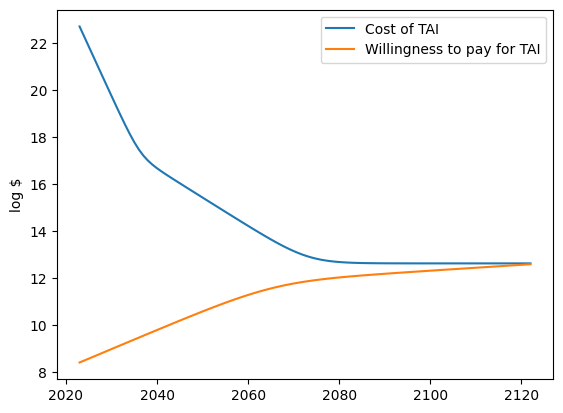

-
-
## SAMPLE RUN 38 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~115 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 2.0 years to a max of 0.056312% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.6 max log FLOP (386 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (761 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.4 (273 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (1 octillion) available - TAI 

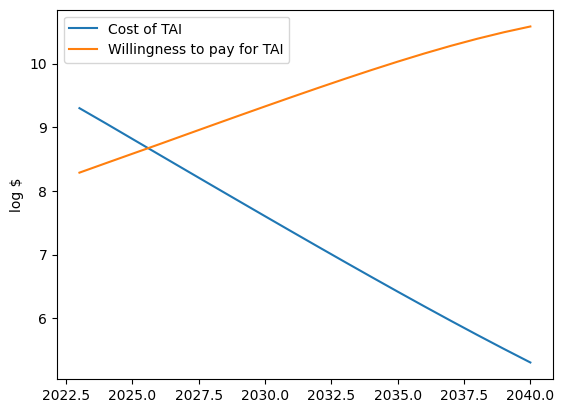

-
-
## SAMPLE RUN 39 ##
It takes 39.6 log FLOP (~4 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 1.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 39.6 log FLOP (4 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (776 quintillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLOP (4 octil

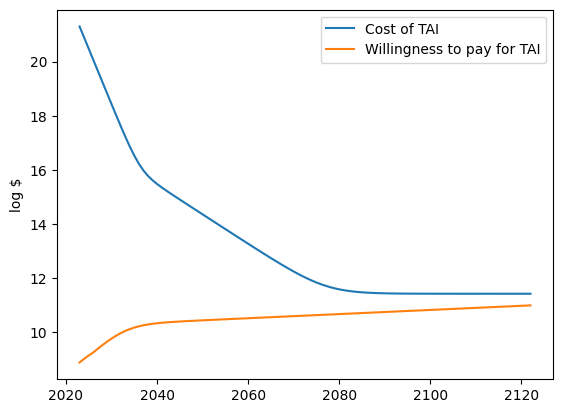

-
-
## SAMPLE RUN 40 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 38.8 log FLOP (631 thousand decillion) - log $ 20.5 to buy TAI (317 quintillion) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.1 to buy TAI (122 quintillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLO

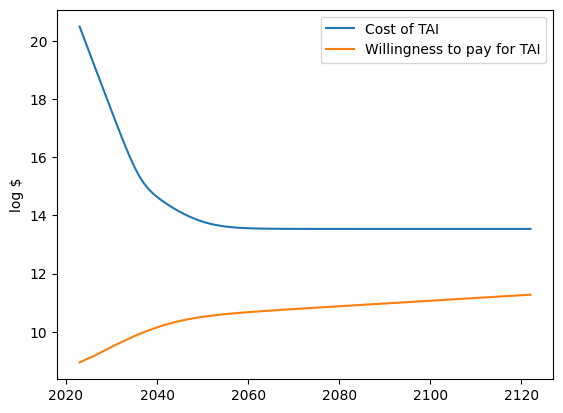

-
-
## SAMPLE RUN 41 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 3.8 years to a max of 0.038897% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.5 max log FLOP (305 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.6 to buy TAI (398 million) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (475 septillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 8.4 to buy TAI (246 million) vs. willingness to pay log $ 8.3 (183 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (738 septillion) av

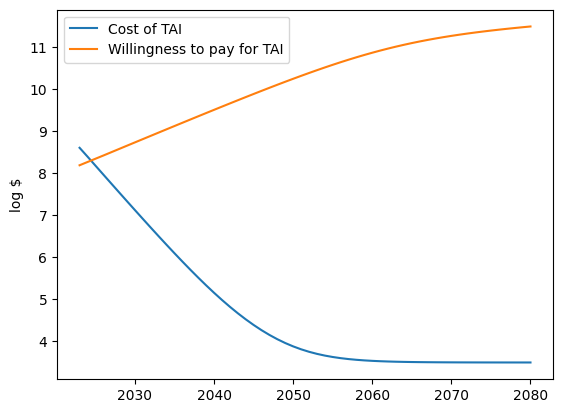

-
-
## SAMPLE RUN 42 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.0 years to a max of 0.124499% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.0 max log FLOP (100 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.7 to buy TAI (501 million) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (158 septillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.5 to buy TAI (318 million) vs. willingness to pay log $ 7.8 (63 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (252 septillion) available 

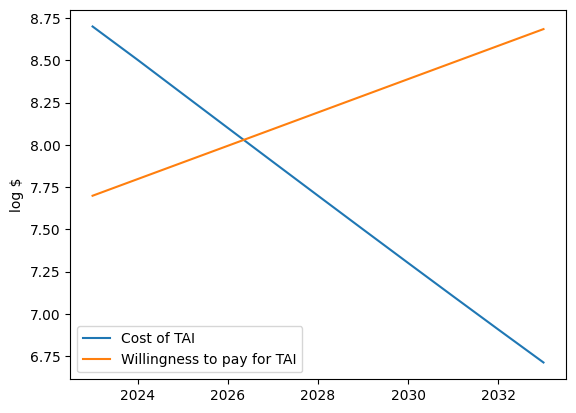

-
-
## SAMPLE RUN 43 ##
It takes 40.0 log FLOP (~10 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21 sextillion) per 2022$USD.
We are initially willing to pay 7.3 log 2022$USD (~20 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 25.6 max log FLOP (40 septillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 7.3 (20 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 25.8 max log FLOP (66 septillion) available - TAI takes 39.7 log FLOP (5 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 7.4 (25 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.0 max log FLOP (111 

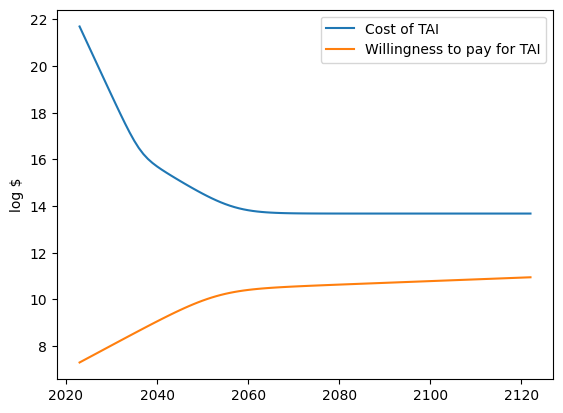

-
-
## SAMPLE RUN 44 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~37 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 3.4 years to a max of 0.45702% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.4 max log FLOP (251 septillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.1 (126 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (402 septillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (39 billion) vs. willingness to pay log $ 8.2 (154 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (646 septillion) ava

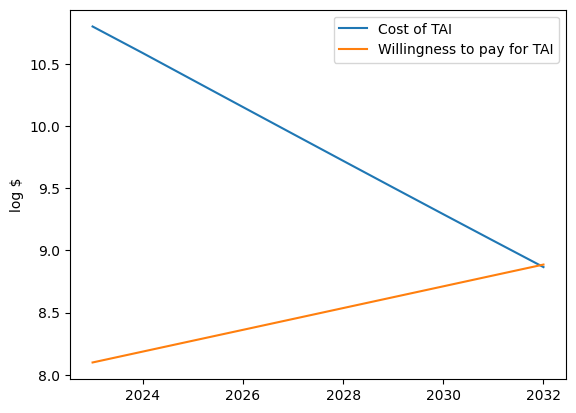

-
-
## SAMPLE RUN 45 ##
It takes 32.2 log FLOP (~158 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~410 quintillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 3.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 32.2 log FLOP (158 nonillion) - log $ 13.9 to buy TAI (80 trillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 32.1 log FLOP (114 nonillion) - log $ 13.6 to buy TAI (42 trillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.8 max log FLOP (7 octillion) available - TAI 

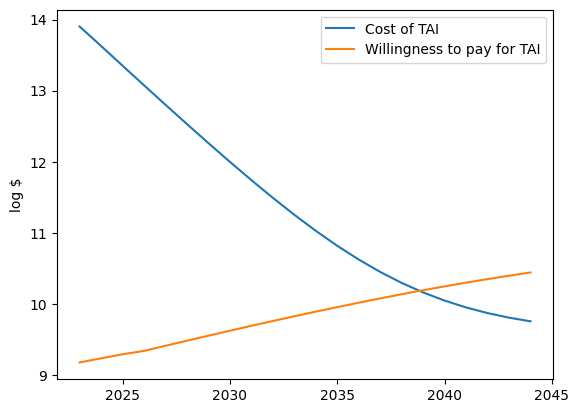

-
-
## SAMPLE RUN 46 ##
It takes 25.7 log FLOP (~50 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~56 sextillion) per 2022$USD.
We are initially willing to pay 9.5 log 2022$USD (~3 billion). This doubles every 4.0 years to a max of 0.037757% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 25.7 log FLOP (50 septillion) - log $ 7.4 to buy TAI (25 million) vs. willingness to pay log $ 9.4 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -- this delay is 4 years (tot

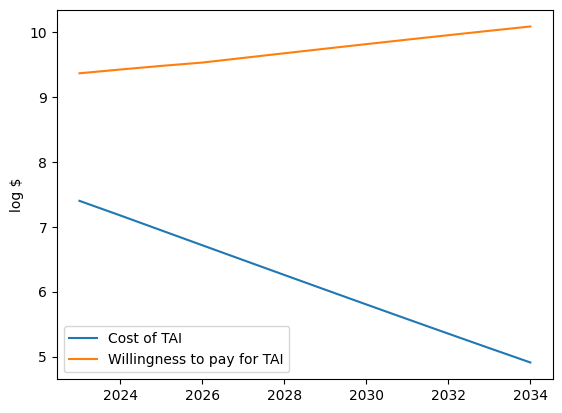

-
-
## SAMPLE RUN 47 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 2.4 years to a max of 0.069943% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 38.3 log FLOP (200 thousand decillion) - log $ 20.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.6 to buy TAI (39 quintillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.0 max log FL

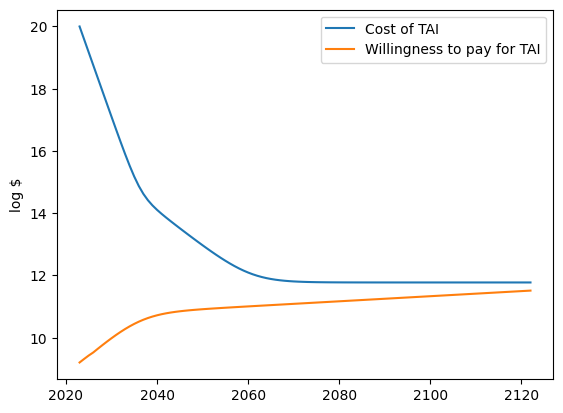

-
-
## SAMPLE RUN 48 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 20.5 log FLOP (~343 quintillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 25.9 max log FLOP (78 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.5 to buy TAI (318 million) vs. willingness to pay log $ 7.6 (39 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (119 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.3 to buy TAI (204 million) vs. willingness to pay log $ 7.7 (48 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 26.3 max log FLOP (182 septillion) availa

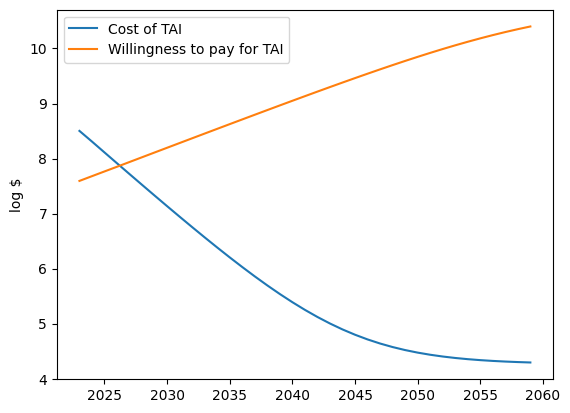

-
-
## SAMPLE RUN 49 ##
It takes 43.9 log FLOP (~79 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.6 years to a max of 0.036292% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 43.9 log FLOP (79 billion decillion) - log $ 25.6 to buy TAI (40 septillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (261 septillion) available - TAI takes 43.6 log FLOP (40 billion decillion) - log $ 25.2 to buy TAI (15 septillion) vs. willingness to pay log $ 8.0 (101 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log F

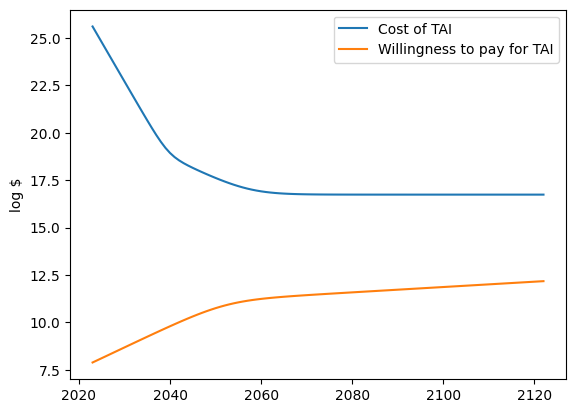

-
-
## SAMPLE RUN 50 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.6 years to a max of 0.148049% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (200 septillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (61 billion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (321 septillion) avail

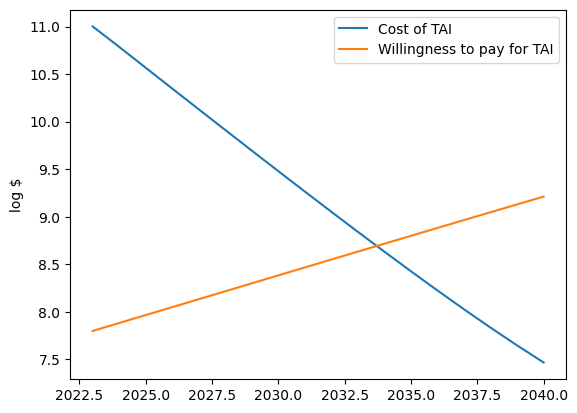

-
-
## SAMPLE RUN 51 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 2.6 years to a max of 0.055207% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 7.5 (31 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (108 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 7.6 (41 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.3 max log FLOP (187 septillion) available - T

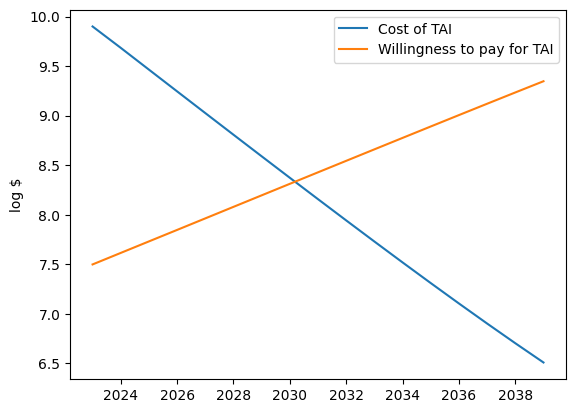

-
-
## SAMPLE RUN 52 ##
It takes 29.7 log FLOP (~501 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~83 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~939 million). This doubles every 3.8 years to a max of 0.066919% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.7 log FLOP (501 octillion) - log $ 11.4 to buy TAI (251 billion) vs. willingness to pay log $ 8.9 (885 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 29.6 log FLOP (403 octillion) - log $ 11.2 to buy TAI (161 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log FLOP (4 octillion) available -

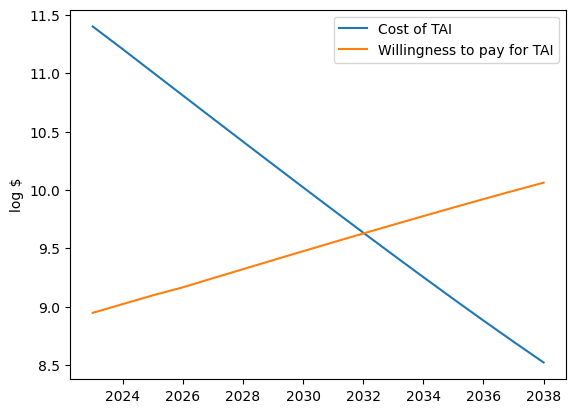

-
-
## SAMPLE RUN 53 ##
It takes 36.3 log FLOP (~2 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~245 million). This doubles every 1.6 years to a max of 0.046512% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.7 max log FLOP (479 septillion) available - TAI takes 36.3 log FLOP (2 thousand decillion) - log $ 18.0 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.4 (240 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (962 septillion) available - TAI takes 36.0 log FLOP (1000 decillion) - log $ 17.6 to buy TAI (381 quadrillion) vs. willingness to pay log $ 8.6 (366 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FL

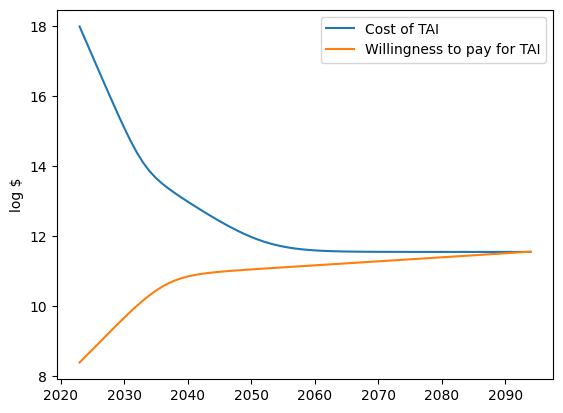

In [20]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)